In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss

import lightfm
import lightfm.data as ld
import lightfm.evaluation as lv

import tqdm
import json
import optuna

import tensorboardX as tb

import matplotlib.pyplot as pl
import seaborn as sns

np.random.seed(31337)

/Users/n.anokhin/Projects/virtualenv/recsys-course/lib/python3.8/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
DATA_DIR = "/Users/n.anokhin/Desktop/"

In [3]:
data = pd.read_json(DATA_DIR + "input.json", lines=True).drop_duplicates(subset=["user", "track"])

In [6]:
positives = data[data["time"] > 0.8].copy()
positives["test"] = np.random.random(len(positives)) >= 0.7

In [7]:
user_counts = positives[~positives["test"]].groupby("user").size()
users = set(user_counts[user_counts >= 5].index.values)

In [8]:
track_counts = positives[~positives["test"]].groupby("track").size()
tracks = set(track_counts[track_counts >= 5].index.values)

## Train LightFM

In [13]:
train_data = positives[~positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]
test_data = positives[positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]

len(train_data), len(test_data)

(44144, 15787)

In [14]:
dataset = ld.Dataset()
dataset.fit(users, tracks)

In [15]:
train_interactions, _ = dataset.build_interactions(train_data[["user", "track"]].itertuples(index=False, name=None))
test_interactions, _ = dataset.build_interactions(test_data[["user", "track"]].itertuples(index=False, name=None))

In [36]:
def fit_model(
    epochs=1, 
    at=10,
    loss="warp",
    no_components=30,
    learning_rate=0.01, 
    max_sampled=10,
    user_alpha=0.0, 
    item_alpha=0.0, 
    threads=30, 
    verbose=False,
    patience=3,
    epsilon=1e-6,
):
    model = lightfm.LightFM(
        no_components=no_components,
        loss=loss,
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=item_alpha,
    )

    precisions_at = []
    
    for epoch in range(epochs):
        model = model.fit_partial(train_interactions, num_threads=threads)
        
        precision_at = lv.precision_at_k(model, test_interactions, train_interactions=train_interactions, k=at, num_threads=threads)
        
        if verbose:
            print(f"{epoch}:\t{np.mean(precision_at)} +/- {ss.sem(precision_at) * 1.96}")
            
        precisions_at.append(np.mean(precision_at))
            
        if epoch > patience and all([precisions_at[-j] - precisions_at[-patience-1] < epsilon for j in range(1, patience + 1)]):
            if verbose:
                print("Early stopiing!")
            break
        
    else:
        if verbose:
            print("No early stopiing happened: increase epochs maybe?")
        
    return model, precisions_at


def objective(trial):
    loss = trial.suggest_categorical("loss", ["warp", "bpr"])
    no_components = trial.suggest_categorical("no_components", [10, 30, 50])
    learning_rate = trial.suggest_categorical("learning_rate", [0.0001, 0.001, 0.01])
    max_sampled = trial.suggest_categorical("max_sampled", [10, 20, 50, 100])
    user_alpha = trial.suggest_categorical("user_alpha", [0.0, 0.0001])
    item_alpha = trial.suggest_categorical("item_alpha", [0.0, 0.0001])
    
    model, precisions_at = fit_model(
        epochs=5, 
        at=10,
        loss=loss,
        no_components=no_components, 
        learning_rate=learning_rate, 
        max_sampled=max_sampled, 
        user_alpha=user_alpha, 
        item_alpha=item_alpha,
    )
    
    return precisions_at[-1]

In [32]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
best_params = study.best_params

[I 2023-03-22 18:49:45,437] A new study created in memory with name: no-name-0296259b-5415-43a7-826a-62abade10163
[I 2023-03-22 18:49:51,764] Trial 0 finished with value: 0.0009309791494160891 and parameters: {'loss': 'bpr', 'no_components': 30, 'learning_rate': 0.01, 'max_sampled': 100, 'user_alpha': 0.0, 'item_alpha': 0.0001}. Best is trial 0 with value: 0.0009309791494160891.
[I 2023-03-22 18:49:58,367] Trial 1 finished with value: 0.0012359550455585122 and parameters: {'loss': 'bpr', 'no_components': 50, 'learning_rate': 0.0001, 'max_sampled': 20, 'user_alpha': 0.0, 'item_alpha': 0.0001}. Best is trial 1 with value: 0.0012359550455585122.
[I 2023-03-22 18:50:04,801] Trial 2 finished with value: 0.010016052052378654 and parameters: {'loss': 'warp', 'no_components': 50, 'learning_rate': 0.0001, 'max_sampled': 50, 'user_alpha': 0.0, 'item_alpha': 0.0}. Best is trial 2 with value: 0.010016052052378654.
[I 2023-03-22 18:50:11,143] Trial 3 finished with value: 0.010048153810203075 and pa

In [33]:
best_params

{'loss': 'warp',
 'no_components': 50,
 'learning_rate': 0.01,
 'max_sampled': 10,
 'user_alpha': 0.0,
 'item_alpha': 0.0001}

In [37]:
model, precisions_at = fit_model(
    epochs=200,
    at=10,
    loss=best_params["loss"],
    no_components=best_params["no_components"], 
    learning_rate=best_params["learning_rate"], 
    max_sampled=best_params["max_sampled"],
    user_alpha=best_params["user_alpha"],
    item_alpha=best_params["item_alpha"],
    verbose=True,
)

0:	0.010465488769114017 +/- 0.0009171752287156609
1:	0.010449439287185669 +/- 0.000912418822883755
2:	0.010465490631759167 +/- 0.0009095885870390506
3:	0.010979133658111095 +/- 0.0009506378762990051
4:	0.01173354871571064 +/- 0.000988579410265518
5:	0.012648475356400013 +/- 0.0010379660313109167
6:	0.013483146205544472 +/- 0.0010820511983270897
7:	0.014269663020968437 +/- 0.0011230832813812226
8:	0.01510433480143547 +/- 0.0011581142838758632
9:	0.015890851616859436 +/- 0.001194226594649267
10:	0.01661316119134426 +/- 0.001229504311933835
11:	0.017223114147782326 +/- 0.0012467513131145021
12:	0.01772070676088333 +/- 0.001271970985524973
13:	0.018105939030647278 +/- 0.0012794985155590022
14:	0.018491173163056374 +/- 0.0012861414060969403
15:	0.018844302743673325 +/- 0.0013013629778342408
16:	0.019181380048394203 +/- 0.0013047870127927599
17:	0.019309792667627335 +/- 0.001302858900169417
18:	0.01963081955909729 +/- 0.0013074900522234594
19:	0.02003210410475731 +/- 0.0013222031158241906
20

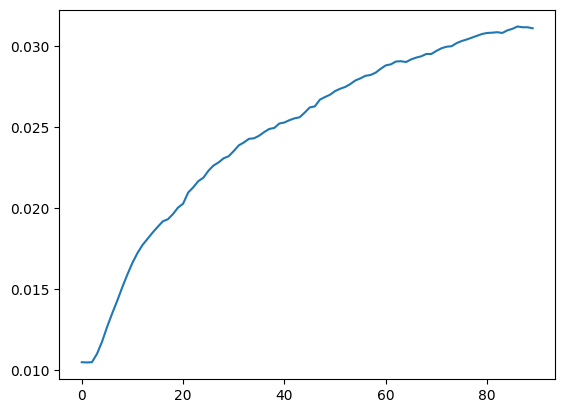

In [38]:
figure, ax = pl.subplots()

ax.plot(np.arange(len(precisions_at)), precisions_at)

pass

## Save track embeddings

In [39]:
biases, embeddings = model.get_item_representations()

In [40]:
model.item_biases *= 0.0

In [41]:
track_meta = pd.read_json(DATA_DIR + "tracks.json", lines=True)
track_meta["dataset_index"] = track_meta["track"].map(lambda t: dataset.mapping()[2].get(t))

In [42]:
dataset_tracks = track_meta[pd.notnull(track_meta["dataset_index"])].sort_values("dataset_index")

In [43]:
writer = tb.SummaryWriter(comment='msd_ligtfm_embeddings', log_dir=DATA_DIR + "tb")
writer.add_embedding(embeddings, metadata=list(dataset_tracks[["artist", "title"]].itertuples(index=False, name=None)), tag="lightfm", metadata_header=["artist", "title"])
writer.close()

## Compute top recommendations

In [44]:
tracks = dataset_tracks["track"].values
users = [user for user, index in sorted(dataset.mapping()[0].items(), key=lambda kv: kv[1])]

In [45]:
with open(DATA_DIR + "recommendations.json", "w") as rf:
    for user_index in tqdm.tqdm(range(dataset.user_features_shape()[0])):
        predictions = model.predict(user_index, np.arange(dataset.item_features_shape()[0]), num_threads=30)
        top = tracks[np.argsort(predictions)[-100:]]
        recommendation = {
            "user": int(users[user_index]),
            "tracks": [int(x) for x in top]
        }
        rf.write(json.dumps(recommendation) + "\n")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7890/7890 [00:05<00:00, 1438.82it/s]
